# Predicting Areas of Affluence using Yelp Pricing Data

#### Authors: 
- Eddie Yip [LinkedIn](https://www.linkedin.com/in/eddie-yip-2a37324b/) | [Medium](https://medium.com/@eddie.yip2)
- Hadi Morrow [LinkedIn](https://www.linkedin.com/in/hadi-morrow-4b94164b/) | [GitHub](https://github.com/HadiMorrow) | [Medium](https://medium.com/@hadi.a.morrow)
- Mahdi Shadkam-Farrokhi: [GitHub](https://github.com/Shaddyjr) | [Medium](https://medium.com/@mahdis.pw) | [http://mahdis.pw](http://mahdis.pw)

## Problem Statement [Hadi]

While affluence should never be a factor when choosing to provide disaster aid or not, we must consider the following:

- On the assumption that affluence plays a role, one might relate affluency to preparedness. Those who can afford to will always look out for their families at any cost. Those who can not might not be able to prepare as well due to the fact that it is not an option. 

- On the assumption that affluence is not part of a majority class, if we should be miopic with our search efforts we might want to consider saving the masses, those living in tight coridors and those with little to no income. If effect those most suseptible to losing their lives in a major disaster. 

- Using tax data we aim to show that using YELP data dollar signs is enough to predict where we might want to quickly and accuratly align our efforts. 

New Light Technologies as our audience, we hope to show that while using expensive and hard to handle data such as tax data can be more precise, a quick and dirty aproach could be to simply sord though the dollar signs data on yelp. 

---
[Hadi] - Excellent write up! Here are some of my observations - feel free to include or not, totally up to you.
1. It would be nice for the reader if we define 'affluence' here at the start. What do we consider "affluent" in our data (I think we mentioned 15% of the area code?)?
2. As a reader, it would be VERY compelling to have an actual case where a natural disaster occured and the affluent areas weren't affected. If possible, research 1 or 2 cases when affluent areas were better prepared for natural disasters - this will help prove our predictive model has a real use case.
3. Tying into the use case, it might be helpful to mention a realistic disaster scenario when only having Yelp! price data would be useful. Like, there's an emergency and there's little time to pull granular information about the area, but knowing the yelp reviews for an area, allows first-responders to know which areas their efforts will have the most impact

## Executive Summary [Mahdi]

- Difficulty gathering data
- Prompt confusing regarding "affluence"
- Other projects used outside data as metric
- We pulled from API and didn't use old data, which was challenging

## Table of Contents
- [Gathering Data](#Gathering-Data)
- [Loading Data](#Loading-Data)
- [Preliminary Exploratory Data Analysis](#Preliminary-Exploratory-Data-Analysis)
- [Cleaning the Data](#Cleaning-the-Data)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Preparation](#Model-Preparation)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Source Documentation](#Source-Documentation)

## Gathering Data
We got Yelp data using the API - link 
 
We got IRS data using - source [Eddie]

## Loading Data
- [All]
- For map visual, will need [Basemap](https://rabernat.github.io/research_computing/intro-to-basemap.html)
[source 2](https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html)

In [5]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import columnExpander
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression

random_state = 6988

In [ ]:
data_file_path = "./data/total_merged.csv"
df_yelp = pd.read_csv(data_file_path, index_col = 0)
df_yelp.reset_index(drop=True, inplace = True) # same indeces were merged using multiple API calls

In [ ]:
df_yelp.shape

## Preliminary Exploratory Data Analysis
- [All]

In [ ]:
df_yelp.head()

In [ ]:
sum_null = df_yelp.isnull().sum()
sum_null[sum_null > 0]

We have many missing values in the data, however many of the columns are not meaningful for our problem and these columns can be safely dropped.

Also, `categories`, `location`, and `transactions` are compressed data columns and will need to be unpacked.

## Cleaning the Data
- [Mahdi] one person for consistency

### Yelp Price

In [ ]:
df_yelp["price"].isnull().sum()

We decided to drop null prices from analysis as this is the key indicator we're looking to predict with.

In [ ]:
df_yelp.dropna(subset=["price"], inplace = True)

In [ ]:
df_yelp.shape

### Converting Yelp Price to ordinal values

In [ ]:
df_yelp['price'] = df_yelp['price'].map({'$': 1, '$$': 2, '$$$': 3, '$$$$':4})

In [ ]:
df_yelp['price'].value_counts()

### Dropping unneccessary columns

In [ ]:
keepers = ['categories','id', 'location', 'price', 'rating', 'review_count', 'transactions', 'coordinates']
df_yelp = df_yelp[keepers]

### Parsing location data

In [ ]:
def get_keys_from_sting_dict(string, keys):
    if len(string) == 0:
        return None
    dic = literal_eval(string)
    out = {}
    for key in keys:
        out[key] = dic.get(key)
    return out

In [ ]:
location = "location"
keys = ["zip_code", "city", 'state']
zips_and_cities = df_yelp[location].map(lambda string: get_keys_from_sting_dict(string, keys))

for key in keys:
    df_yelp[key] = [pair[key] for pair in zips_and_cities]
    
df_yelp.drop(columns=[location], inplace = True)

### Filtering for NYC-only

#### Removed non-NY state

In [ ]:
df_yelp = df_yelp[df_yelp['state'] == "NY"]

#### Imputing missing zip codes

In [ ]:
df_yelp[df_yelp['zip_code'] == ""]

Locations were found using Google Maps and zip codes imputed manually

In [ ]:
df_yelp.loc[df_yelp["id"] == "ECY0sIYxPJio81dteqiMhg","zip_code"] = "10007"
df_yelp.loc[df_yelp["id"] == "6u5cnsN35mJz24HMQ9pfFw","zip_code"] = "10314"
df_yelp.loc[df_yelp["id"] == "BilbRcNQXKmcBFvLm4gxAQ","zip_code"] = "11372"
df_yelp.loc[df_yelp["id"] == "jZzbV6SRt9FXdCoziNv5xw","zip_code"] = "11373"

### Remove by NYC zip
We used the range of zip codes designated for NYC - [source](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php)

In [ ]:
min_zip = 10001
max_zip = 11697

df_yelp['zip_code'] = df_yelp['zip_code'].astype(int)

In [ ]:
df_yelp = df_yelp[(df_yelp['zip_code'] >= min_zip) & (df_yelp['zip_code'] <= max_zip)]

### Parsing Coordinates

In [ ]:
coordinates = "coordinates"
coord_keys = ["latitude", "longitude"]
lat_and_long = df_yelp[coordinates].map(lambda string: get_keys_from_sting_dict(string, coord_keys))

for key in coord_keys:
    df_yelp[key] = [pair[key] for pair in lat_and_long]

df_yelp.drop(columns=[coordinates], inplace = True)

In [ ]:
df_yelp[coord_keys].describe()

Looking at the latitude and longitude, we see some points that do not appear to be in the New York City area, around 40.7 and -73.9, respectively.

In [ ]:
df_yelp[(df_yelp["latitude"] > 41) | (df_yelp["latitude"] < 40)]

This data point is from Scarsdale NY, which is not within the city limits. This data point will be dropped.

In [ ]:
df_yelp = df_yelp[(df_yelp["latitude"] <= 41) & (df_yelp["latitude"] >= 40)]

In [ ]:
df_yelp[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75)]

After looking up these businesses, it is clear they were given a positive longitude when they are actually supposed to be negative.

In [ ]:
df_yelp.loc[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75),"longitude"] = np.negative(df_yelp[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75)]["longitude"])

### Parsing categories

In [ ]:
def convert_string_dict_to_string(string, key):
    return ",".join([dic[key] for dic in literal_eval(string)])

df_yelp["categories"] = df_yelp["categories"].map(lambda s: convert_string_dict_to_string(s,"alias"))

### Parsing transactions

In [ ]:
def convert_string_list_to_string(string):
    return ",".join(literal_eval(string))

df_yelp["transactions"] = df_yelp["transactions"].map(convert_string_list_to_string)

In [ ]:
df_yelp.shape

In [ ]:
df_yelp.isnull().sum().sum()

There are no null values - this is a complete dataset

### Cleaning IRS Dataset [Hadi]
These data were collected directly from the IRS website ([source](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi))

In [ ]:
df_irs = pd.read_csv('./data/irs.csv')

In [ ]:
df_irs[10:20]

In [ ]:
yelp_zips = list(set(df_yelp['zip_code']))

In [ ]:
def clean_str_num(str_num):
    '''Returns integer of input string with commas removed'''
    return int(str_num.replace(',',''))

In [ ]:
affluency_rates = []
found_zips = []
missing_zips = []
returns_col_name = 'Number of returns'

for zip_code in yelp_zips:
    try:
        sub_df               = df_irs[df_irs.iloc[:,0] == str(zip_code)]
        
        affluent_irs_returns = clean_str_num(sub_df[returns_col_name].iloc[-1])
        total_irs_returns    = clean_str_num(sub_df[returns_col_name].iloc[0])
        affluent_rate        = affluent_irs_returns / total_irs_returns
        
        affluency_rates.append(affluent_rate)
        found_zips.append(zip_code)
    except Exception as e:
        missing_zips.append(zip_code)
        pass

In [ ]:
len(missing_zips)

There are 26 zip codes in the yelp data that were not found in the IRS dataset.  
These associated datapoint will be dropped, as they have not target value.

In [ ]:
affluency_df = pd.DataFrame(data = {"zip_code": found_zips, "affluency_rate":affluency_rates})
affluency_df.head()

### Merging Yelp and IRS dataset
Merging the yelp dataset with the IRS dataset will drop those observations with missing zip codes.

In [ ]:
df = pd.merge(df_yelp, affluency_df, on = "zip_code")

In [ ]:
df.shape

### Changing Data Type

In [ ]:
df.dtypes

In [ ]:
convert_to_int = ["review_count","rating"]
df[convert_to_int] = df[convert_to_int].astype(int)

In [ ]:
df.head(2)

In [ ]:
df.shape

We are left with 8869 complete data points

## Feature Engineering
- [All]

### Creating Dummy Variables

In [ ]:
expansion_columns = ["categories","transactions"]
lce = columnExpander.ListColumnExpander(expansion_columns)

In [ ]:
dummy_df = pd.DataFrame(lce.fit_transform(df).toarray(), columns=lce.get_feature_names())

In [ ]:
complete_df = pd.concat([df, dummy_df], axis=1)

In [ ]:
complete_df = pd.concat([df.drop(columns = expansion_columns), dummy_df], axis=1)
complete_df.head(2)

### Reducing Latitude and Longitude using clustering
We decided to reduce the latitude and longitude variables into a single column using $K$-means clustering as a way of representing more local neighborhoods.

An optimum $k$ will be determined using the model's silhouette score.

In [7]:
def get_kmean_sil_score(data, k, random_state):
    return silhouette_score(data,KMeans(n_clusters = k, n_jobs = -1, random_state = random_state).fit(data).labels_)

In [8]:
#Setting up K-means scree plot
max_k = 14

lat_long_df = StandardScaler().fit_transform(complete_df[["latitude","longitude"]]) # not 100% necessary to scale
scores = []
best_k = {"k":0,"score":0}
all_k  = range(2, max_k + 1)
best_km = None
for k in all_k:
    score = get_kmean_sil_score(lat_long_df, k, random_state)
    scores.append(score)
    if score > best_k["score"]:
        best_k["score"] = score
        best_k["k"] = k

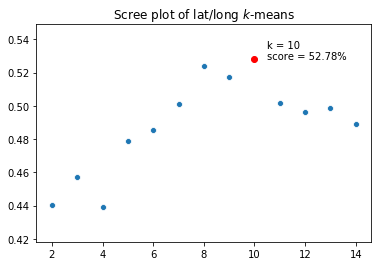

In [9]:
plt.title("Scree plot of lat/long $k$-means")
sns.scatterplot(all_k, scores)
plt.plot(best_k["k"],best_k["score"], "ro")
plt.text(best_k["k"] + .5 ,best_k["score"], "k = {}\nscore = {:.2%}".format(best_k['k'],best_k['score']));

According to the silhouette score, an optimum number of clusters for longitude and latitude occur is 10.

In [10]:
km = KMeans(n_clusters= best_k["k"], random_state = random_state)
km.fit(lat_long_df)
complete_df["location_cluster"] = km.labels_

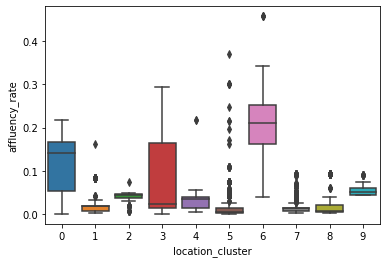

In [14]:
sns.boxplot(data = complete_df, x = "location_cluster", y = "affluency_rate");

# GET SENSE OF WHAT NEIGHBORHOODS THESE AREAS CORRESPOND TO

### Visualizing 

### Setting Affluency Threshold
Affluency = when a zip code has 15% of its population file and IRS return of $$200k or more

In [ ]:
affluency_thresh = .15

In [ ]:
complete_df["is_affluent"] = (complete_df["affluency_rate"] >= affluency_thresh).astype(int)
complete_df["is_affluent"].value_counts(normalize = True)

About 28% of all reported IRS returns in New York City count as being affluent, according to our definition.

This leads our data to be somewhat unbalanced, which we need to keep in mind when evaluating our models.

## Exploratory Data Analysis
- [Mahdi] and [Hadi] killer graphs and visuals

# Below is work in progress
# ============

## Mahdi's tasks
1. ~~Refine and visualize K-means optimization~~
1. Clean up map visual - COULDN'T GET THIS WORKING
1. ~~Create bar plot of clusters related to affluency~~
1. Check by city

Visualizing affluency by location

In [3]:
!pip install --upgrade pip

Requirement already up-to-date: pip in c:\users\rick_c137\anaconda3\lib\site-packages (19.2.1)


In [10]:
# Preparing map data
# import pandas as pd
# %matplotlib inline
# import numpy as np
# import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# Extract the data we're interested in
# lat = df['latitude'].values
# lon = df['longitude'].values
# price = df['price'].values
# rating = df['rating'].values

KeyError: 'PROJ_LIB'

In [52]:
# Let's cluster our observations by lat/long
km = KMeans(n_clusters=20)
km.fit(location_data)`

NameError: name 'location_data' is not defined

In [ ]:
# Where are the highly prices houses?
location_data.plot(kind="scatter", x="latitude", y="longitude",
         cmap="inferno", figsize=(14, 10), s=2);

In [ ]:
# What do these clusters look like visually?
plt.figure(figsize=(10, 10))
plt.scatter((location_data.latitude).astype(float), (location_data.longitude).astype(float), c=km.labels_, s=50 ,cmap="tab20");

In [ ]:
min(lat)

In [ ]:
min(lon)

In [ ]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(resolution = 'i', projection = 'cyl',
            llcrnrlat=40.35868, llcrnrlon=-74.491350,
            urcrnrlat = 41.163819, urcrnrlon = -73.447253,epsg = 3395)
m.shadedrelief()
m.arcgisimage(service ="ESRI_Imagery_World_2D", xpixels = 2000)
# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=(price)**3, s=(rating)*4,
          cmap='Reds', alpha=0.5)

# 3. arcgisimage
plt.savefig("ESRI_Imagery_World_2D", bbox_inches = "tight", dpi = 500)

In [ ]:
# Train-test-split again
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.5
)

In [ ]:
# How'd we do now?
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

In [ ]:
# All this wrapped up!
def transfer_tune(X, y, k):
    location_data = df_yelp[["latitude", "longitude"]]
    km = KMeans(n_clusters=k)
    km.fit(location_data)
    X.loc[:, "cluster"] = km.predict(location_data)
    X_dummy = pd.get_dummies(columns=["cluster"], data=X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.5
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    r2 = model.score(X_test, y_test)
    print(f"{k} : {r2}")

In [ ]:
for k in range(2, 103, 5):
    transfer_tune(X, y, k)

In [ ]:
sns.scatterplot(data = df, x = 'affluency_rate', y = 'zip_code')

# ============
# Above is work in progress

## Saving/Loading Clean data

In [ ]:
# complete_df.to_csv("./data/clean_data.csv")

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import columnExpander
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
complete_df = pd.read_csv("./data/clean_data.csv", index_col = 0)

In [ ]:
complete_df.head()

## Model Preparation

In [ ]:
remove_columns = [
    'id',
    'zip_code',
    'city',
    'state',
    'latitude',
    'longitude',
    'affluency_rate',
    'transactions_'
]
target = 'is_affluent'

In [ ]:
X = complete_df.drop(columns=remove_columns+[target])
y = complete_df[target]

## Model Selection
- [Hadi] Exploring models
- [Eddie] Exploring models

Maybe split on which models you 2 want to try out

## Model Evaluation
- [Mahdi] killer graphs and visuals

## Conclusions and Recommendations
- [All]

## Source Documentation
- [NYC zip codes](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php)
- [Yelp API - Business Endpoints](https://www.yelp.com/fusion)
- [IRS dataset](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi)